In [4]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import os.path as path
import sys
import re
import json
import datetime
from datetime import timedelta

import theano
import theano.tensor as t
import pymc3 as pm
from pymc3.model_graph import ModelGraph, model_to_graphviz
from pymc3 import glm

from IPython.display import display, Markdown, Latex

from utils import kde_scatter, bayesian_correlation, summary

import warnings
warnings.filterwarnings("ignore", "dropping on a non-lexsorted multi-index without a level parameter may impact performance", append=True)


%matplotlib inline
%load_ext autoreload

%autoreload 2

In [5]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams["font.size"] = "24"
sns.set(font_scale=1.5)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 16)

In [6]:
DATAPATH = 'data/SN1'

In [7]:
dfs = []
df_values = []

for file in [x for x in os.listdir(DATAPATH) if '.json' in x]:
    with open(os.path.join(DATAPATH, file), 'r') as f:
        data = json.load(f)
        df = pd.DataFrame(data.pop('activity'))
        day = re.findall('[0-9]{4}-[0-9]{2}-[0-9]{2}', file)[0]
        df['day'] = day
        df['datetime'] = pd.to_datetime(df.day + ' ' + df.activity_time)
        df = df.drop(columns=['activity_time', 'day'])
        dfs.append(df)
        
        data['day'] = pd.to_datetime(day)
        df_values.append(data)
        
df = pd.concat(dfs).reset_index(drop=True)

df = df.sort_values('datetime')
df = df.iloc[2:] # drop day 1

# Count nighttime spent
df['timespent'] = -(df.datetime.astype(np.int64).diff(-1)//1e9).apply(lambda x: pd.Timedelta(seconds=x) if not np.isnan(x) else pd.Timedelta(seconds=0))
# if next day is missing remove 1 day from timespent
df.timespent = df.timespent.apply(lambda x : x-pd.Timedelta(days=1) if x > pd.Timedelta(days=1) else x)

# Activity type to categories
df.activity_type = df.activity_type.str.strip()
df.activity_type = df.activity_type.astype('category')

df = df.iloc[:-1] # remove last sleep

df_values = pd.DataFrame(df_values)
df_values = df_values.set_index('day')
df_values = df_values.rename(columns={'tiredness':'fatigue', 'workload':'effort physique'})

![Sentinelle Nord](https://sentinellenord.ulaval.ca/themes/custom/sn_front/sn_integration/app/assets/images/components/logo-sentinelle-noir-fr.png "Sentinelle Nord")

# Raport initial expédition 2018 SN 2.8
## participant 1



# Statistiques de base

### Exemple de données récoltées

In [8]:
df.head()

,activity_name,activity_type,datetime,timespent
2,Lever,Lever (nuit),2018-07-05 04:45:00,00:15:00
3,Préparations à la journée - déplacements de to...,Soins d’hygiène et habillage,2018-07-05 05:00:00,01:00:00
4,Transit en taxi,Autres activités,2018-07-05 06:00:00,00:30:00
5,Attente aéroport - surtout en position assise,Travail en position assise,2018-07-05 06:30:00,01:55:00
6,Transit en avion,Autres activités,2018-07-05 08:25:00,03:05:00


### Heures de sommeil

In [9]:
moyen = df[df.activity_type=='Coucher (nuit)'].timespent.mean()
print("Nombre d'heure de sommeil moyen ", str(moyen)[7:])

Nombre d'heure de sommeil moyen  06:39:08


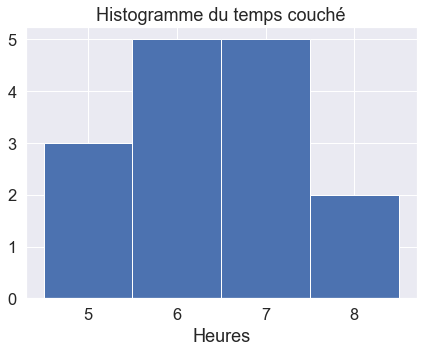

In [10]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot()
ax.hist(df[df.activity_type=='Coucher (nuit)'].timespent.astype(np.timedelta64)//1e9//3600 , bins=[5, 6, 7, 8, 9], align='left')
ax.set_xlabel('Heures')
plt.title('Histogramme du temps couché')
fig.show(warn=False)

### Distribution du temps selon les activités

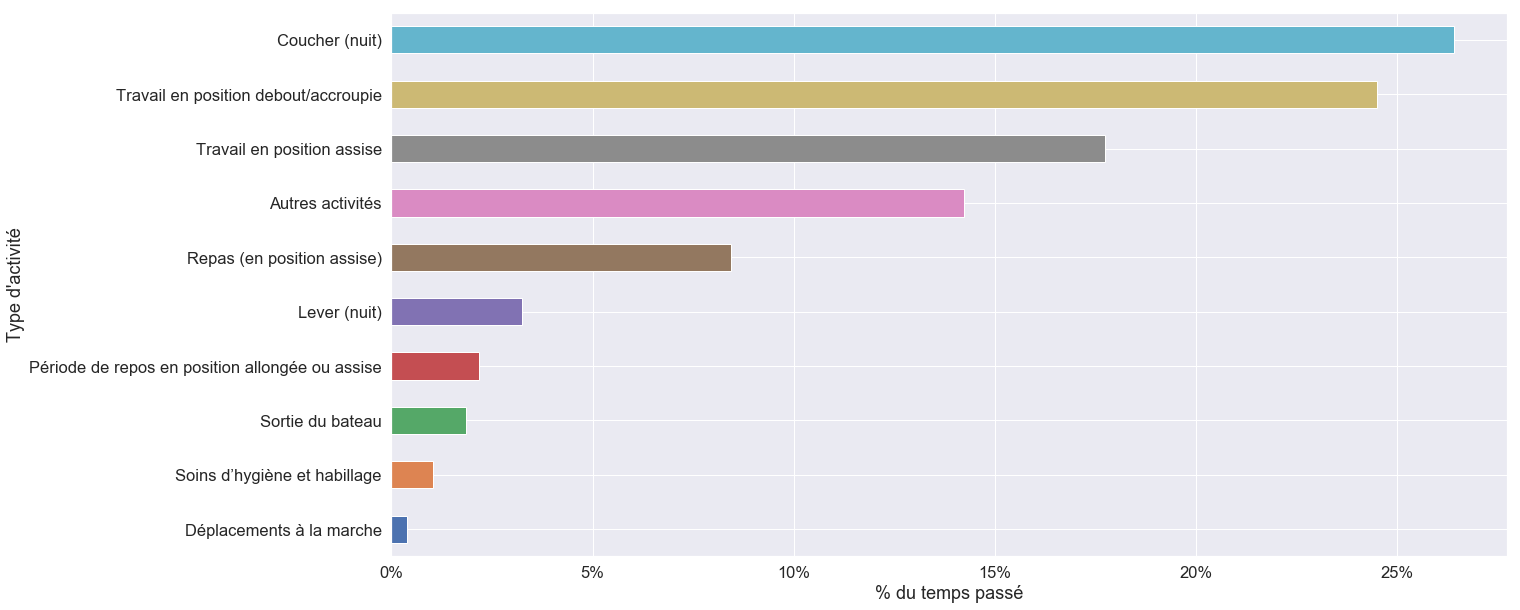

In [11]:
fig = plt.figure()
(df.groupby('activity_type').timespent.sum().astype(np.timedelta64)/df.timespent.astype(np.timedelta64).sum()).sort_values(ascending=True).plot.barh()
vals = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0%}'.format(x) for x in vals])
plt.ylabel('Type d\'activité')
plt.xlabel('% du temps passé')
plt.show()

In [12]:
df['tmp'] = df.activity_name + ';'
activity_details = df.groupby('activity_type').tmp.sum()
df = df.drop(columns=['tmp',])

display(Markdown('## Détails des activités'))

for name, activity_detail in activity_details.iteritems():
    activity_str = activity_detail.split(';')
    activity_str = [x.strip() for x in activity_str]
    activity_str = list(set(activity_str))
    activity_str = list(filter(None, activity_str))
    activity_str = '<br>-'.join(activity_str)
    display(Markdown('**{name}**<br> -{activity_str}'.format(name=name, activity_str=activity_str)))


## Détails des activités

**Autres activités**<br> -Transit autobus<br>-Retrait des capteurs pour une activité d'initiation (risque de salissures...)<br>-Port IMU et Montre<br>-Port IMU et montre et début de déplacements dans le navire<br>-Soirée au pub du navire - échecs et scotch<br>-Soirée pub navire - jeu d'échecs<br>-Port IMU et montre et début déplacements dans le navire (escaliers)<br>-Retrait IMU et montre - constatation que la batterie IMU était déchargée<br>-Vol en avion<br>-Exercice de feu et simulation d'évacuation du navire<br>-Travail au laboratoire en position debout - montée/descente escaliers - déplacements à pied - transfert de caisses lourdes<br>-Transit en taxi<br>-Port de l'uniforme pour ....<br>-Retrait des capteurs<br>-Entrevue (filmée) sur le pont avant du navire<br>-Travail au laboratoire en position debout - montée/descente escaliers - déplacements à pied<br>-Port IMU et montre<br>-Visite du navire avec montée/descente d'escaliers et déplacements à pied<br>-Port IMU et montre (approx)<br>-Travail laboratoire et ordinateur - debout et assis<br>-Retrait du IMU pour changer de vêtements<br>-Retrait des IMU et montre<br>-Retrait IMU et Montre<br>-Activité d'initiation - nor.....<br>-Début du port de l'IMU et la montre<br>-Port des capteurs<br>-Soirée au pub du navire<br>-taxi<br>-Visite médicale de routine - prise de pression sanguine (l'heure est floue dans ma tête, c'est après le déjeuner mais avant 10h00)<br>-Retrait capteurs<br>-retrait des capteurs<br>-Vol en hélicoptère<br>-Soirée échecs et karaoké<br>-Travail au laboratoire en position debout<br>-Transit en avion<br>-Port de capteurs<br>-Soirée fin de leg<br>-Réunion scientifique<br>-Retrait IMU<br>-Retrait IMU et montre<br>-retrait montre

**Coucher (nuit)**<br> -Coucher

**Déplacements à la marche**<br> -Activité sur le pont arrière du navire<br>-Activité physique sur le pont du navire

**Lever (nuit)**<br> -Retrait EMU et montre<br>-Réveil et préparations à la journée<br>-Lever et préparation à ...<br>-Lever et préparations à la journée<br>-Lever<br>-Réveil<br>-Lever - préparations à la journée

**Période de repos en position allongée ou assise**<br> -Repos - film - conversation - position assise<br>-Période de repos<br>-Repos<br>-Attente à l'aéroport -su.....

**Repas (en position assise)**<br> -Souper<br>-Déjeuner<br>-Pause café<br>-Souper du dimanche avec vin<br>-souper<br>-Dejeuner<br>-Diner<br>-Pause + réunion de groupe

**Soins d’hygiène et habillage**<br> -Préparations à la journée - déplacements de toutes sortes<br>-Douche - retrait capteurs<br>-Retrait IMU et montre (douche et repos)<br>-Changement de vêtements (transfert du IMU - recalibration)<br>-Retrait capteur (douche)<br>-Changement de "costume" pour le souper du dimanche (plus chic)

**Sortie du bateau**<br> -Marche dans le village - visite musée - dégustation mets locaux<br>-Retour au navire et préparation activités<br>-Départ pour une sortie à terre (Qikiqtarjuaq)

**Travail en position assise**<br> -Réunion organisation d'activités - assis surtout mais parfois debout avec déplacement<br>-Réunion organisation d'activités<br>-Travail de bureau et de préparations à une entrevue (surtout assis)<br>-Port IMU et montre et ensuite travail de bureau essentiellement assis (quelques escaliers et déplacements)<br>-Attente aéroport - surtout en position assise<br>-Travail de groupe<br>-Travail de bureau .....<br>-Travail de laboratoire assis/debout au noir<br>-Après-midi conférences (auditrice)<br>-Travail de bureau surtout assis, avec quelques déplacements à la buanderie (matinée de lessive)<br>-Atelier de travail de groupe<br>-Travail de bureau<br>-Réunion scientifique et conférences<br>-Réunion de science<br>-Travail de bureau surtout assis quelques déplacement<br>-Travail de bureau entrecoupé de visites ponctuelles au laboratoire<br>-Réunion science<br>-Travail avec les étudiants<br>-Travail bureau<br>-Travail de bureau et plusieurs déplacements dans le navire<br>-Travail de bureau (surtout assis, parfois debout)<br>-Travail de bureau surtout assis, avec quelques déplacements au laboratoire<br>-Prise de notes Journal SN capteurs à l'ordinateur entrecoupée de déplacements dans le navire<br>-Travail à l'ordinateur<br>-Réunion scientifique<br>-Réunion scientifique avec.....<br>-Travail de bureau (préparation de cours pour l'école d'été SN) surtout assis, quelques déplacements<br>-Matinée conférences (auditrice)<br>-Travail sur le rapport de ....

**Travail en position debout/accroupie**<br> -Formation hélicoptère (visite de l'appareil, briefing sécurité)<br>-Travail en laboratoire debout et assis - stress à cause d'un bris d'instrument<br>-Travail sur le pont avant et en laboratoire<br>-Attente du départ en hélicoptère<br>-Fermeture des systèmes ....<br>-Travail au laboratoire principalement debout avec déplacements et escaliers<br>-Travail au laboratoire principalement debout (un peu d'ordinateur assis) avec déplacements et escaliers<br>-Travail de laboratoire - debout - déplacements- escaliers<br>-Travail en laboratoire et sur le pont avant du navire - déplacements - escaliers<br>-Travail sur le pont avant<br>-Travail de laboratoire debout<br>-Travail en laboratoire - déplacements - escaliers<br>-Ménage de la chambre<br>-Ménage laboratoire<br>-Travail laboratoire debout/assis, déplacements, escaliers.<br>-Travail debout dans un laboratoire à 4oC<br>-Travail de laboratoire intérieur et travail à l'extérieur, déplacements, escaliers etc.<br>-Travail sur le pont avant et en laboratoire - surtout debout - déplacements - escalier<br>-Travail pont avant du navire et en laboratoire debout (surtout quelques fois assis)<br>-Travail sur le pont avant du navire<br>-Travail position debout - escaliers<br>-Travail (surtout debout) au laboratoire, montée/descente d'escaliers<br>-Travail laboratoire debout et assis - déplacements - escaliers<br>-Travail au laboratoire debout<br>-Port IMU et montre / Travail de pont navire (extérieur)<br>-Travail au laboratoire surtout debout mais parfois assis<br>-Travail de laboratoire, surtout debout, déplacements, escaliers. Le laboratoire est froid car les portes doivent rester ouvertes.<br>-Travail de laboratoire (assis et debout) déplacements - escaliers<br>-Travail sur le pont avant et en laboratoire (surtout debout mais aussi assis) - déplacement<br>-Travail laboratoire - déplacements - escaliers<br>-Travail en laboratoire - c...<br>-Travail en laboratoire<br>-Travail d'échantillonnage à la rosette<br>-Travail en laboratoire et sur le pont avant du navire (debout et assis) déplacements - escaliers<br>-Travail laboratoire - position debout principalement - montée/descente escaliers<br>-Travail laboratoire debout et assis - déplacements - escaliers - réparations bris d'instrument<br>-Après-midi conférences (conférencière)<br>-Travail laboratoire debout - déplacements - escaliers<br>-Travail au laboratoire debout et un peu assis

## Indices psychologiques

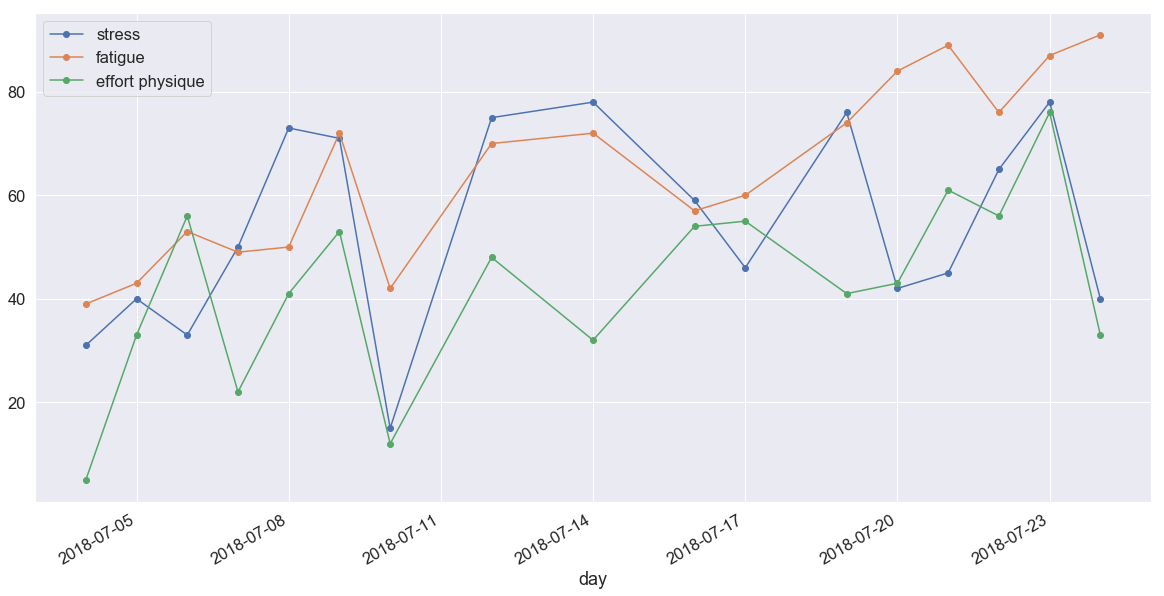

In [13]:
fig = plt.figure()
ax = fig.subplots()
df_values.plot.line(marker='o', ax=ax)
plt.show()

### Corrélations

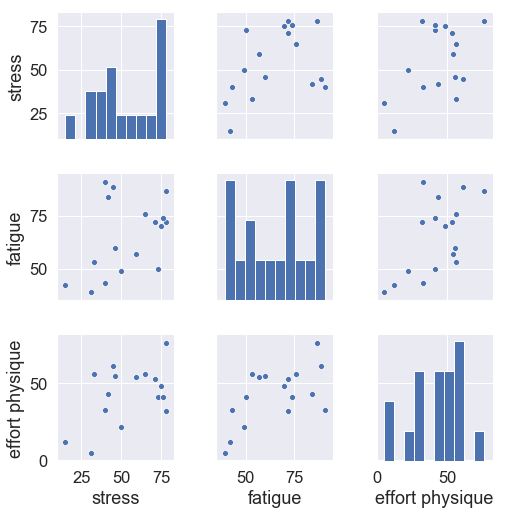

In [14]:
sns.pairplot(data=df_values)
plt.show()

### Corrélation entre le Stress et Effort Physique

In [15]:
trace = bayesian_correlation(df_values.stress.values, df_values['effort physique'].values)

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib

Corrélation Bayésienne avec Student-t likelihood


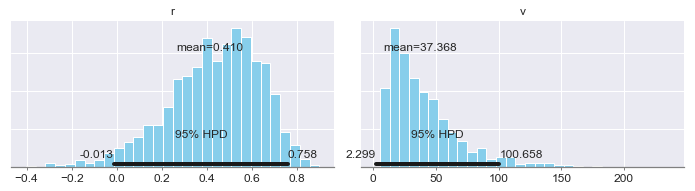

pearson r:0.500, p:0.041147
spearman r:0.307, p:0.230185


In [16]:
print('Corrélation Bayésienne avec Student-t likelihood')
pm.plots.plot_posterior(trace, varnames=['r', 'ν'], figsize=(10,3))
plt.show()
r, p = scipy.stats.pearsonr(df_values.stress.values, df_values['effort physique'].values)
print('pearson r:{:0.3f}, p:{:0.6f}'.format(r, p))
r, p = scipy.stats.spearmanr(df_values.stress.values, df_values['effort physique'].values)
print('spearman r:{:0.3f}, p:{:0.6f}'.format(r, p))

### Corrélation entre le Stress et la Fatigue

In [17]:
trace = bayesian_correlation(df_values.stress.values, df_values['fatigue'].values)

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, μ2, μ1, r, sigma2, sigma1]
Sampling 4 chains: 100%|███████████████| 4000/4000 [00:37<00:00, 107.53draws/s]
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]

Corrélation Bayésienne avec Student-t likelihood


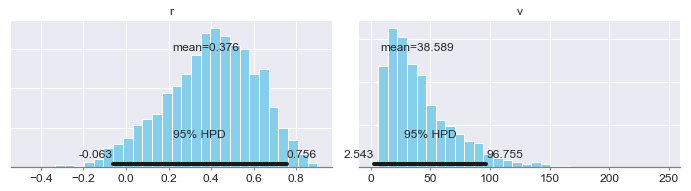

pearson r:0.419, p:0.094209
spearman r:0.397, p:0.114425


In [18]:
print('Corrélation Bayésienne avec Student-t likelihood')
pm.plots.plot_posterior(trace, varnames=['r', 'ν'], figsize=(10,3))
plt.show()
r, p = scipy.stats.pearsonr(df_values.stress.values, df_values['fatigue'].values)
print('pearson r:{:0.3f}, p:{:0.6f}'.format(r, p))
r, p = scipy.stats.spearmanr(df_values.stress.values, df_values['fatigue'].values)
print('spearman r:{:0.3f}, p:{:0.6f}'.format(r, p))

### Corrélation entre Effort Physique et la Fatigue

In [19]:
trace = bayesian_correlation(df_values['effort physique'].values, df_values['fatigue'].values)

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, μ2, μ1, r, sigma2, sigma1]
Sampling 4 chains: 100%|███████████████| 4000/4000 [00:36<00:00, 110.32draws/s]
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]

Corrélation Bayésienne avec Student-t likelihood


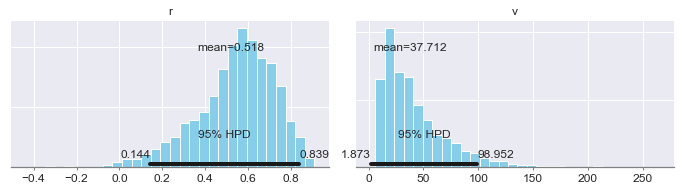

pearson r:0.598, p:0.011262
spearman r:0.554, p:0.021013


In [20]:
print('Corrélation Bayésienne avec Student-t likelihood')
pm.plots.plot_posterior(trace, varnames=['r', 'ν'], figsize=(10,3))
plt.show()
r, p = scipy.stats.pearsonr(df_values['effort physique'].values, df_values['fatigue'].values)
print('pearson r:{:0.3f}, p:{:0.6f}'.format(r, p))
r, p = scipy.stats.spearmanr(df_values['effort physique'].values, df_values['fatigue'].values)
print('spearman r:{:0.3f}, p:{:0.6f}'.format(r, p))

# Commentaires

In [21]:
for day, commentaire in df_values.commentaires.iteritems():
    display(Markdown('**{day}**<br> -{commentaire}'.format(day=day.strftime('%Y-%m-%d'), commentaire=commentaire)))

**2018-07-04**<br> -Je porte IMU pour la première fois sur le bras. Il faudra des ajustements, le bracelet descend souvent, m'obligeant à le replacer et le recalibrer (mouvements des bras x 5 répétitions). 

**2018-07-05**<br> -Je dois dire que le fait que la montre Empatica ne soit pas une montre véritable est quelque peu irritant. En effet, j'ai souvent le réflexe de regarder la montre lorsque j'entame une nouvelle activité afin de marquer l'heure mais comme l'heure n'est pas apparente je dois me fier à un autre médium (téléphone, horloge etc). Bref. Ceci fait en sorte que les heures que j'inscris dans ce journal resteront approximatives pour certaines activités car je n'ai pas toujours accès à cette information au moment même où l'activité est accomplie. En terme de "user-friendliness" ce modèle n'arrive pas à la cheville de la montre testée en 2017. En espérant que du côté prise de données cela en vaille la peine!

**2018-07-06**<br> -6 juillet 2018. Je vois que dans les choix d'activités il existe une catégorie "escaliers". Il m'est pratiquement impossible de monitorer quantitativement ce paramètre puisque les escaliers sur un navire font partie intégrante du "paysage"... Je peux rarement effectuer un déplacement sans emprunter, à un moment ou un autre, un escalier. Pour cette raison, je mentionne escalier dans les activités sans toutefois estimer la quantité. Je ne suis pas certaine que l'EMU tient toute la journée (malgré qu'il passe la nuit entière sur la charge). Aujourd'hui 2 fichiers ont été générés (7.oimu et 8.oimu) et les deux semblent de beaucoup plus petite taille que celui d'hier (5 juillet 2018). 

**2018-07-07**<br> -7 juillet 2018. 

**2018-07-08**<br> -Stress en fin de journée à cause du bris d'un instrument. J'ajoute à ce commentaire le fait que j'ai parfois l'impression de modifier la façon dont je bouge mon bras gauche (celui sur lequel je porte l'IMU). Le brassard glisse souvent et je crois qu'inconsciemment je modifie mes mouvements pour empêcher que cela ne se produise trop fréquemment. Je préfère vous faire part de cette impression. 

**2018-07-09**<br> -9 juillet 2018. J'ai très mal dormi la nuit dernière à cause d'un problème non résolu au niveau d'un de nos appareils tard en soirée, la veille (source de stress pour moi). J'ai dû aussi me lever tôt pour faire un peu de travail sur le pont avant du navire (extérieur), donc une certaine fatigue aujourd'hui. 

**2018-07-10**<br> -10 juillet 2018. Petite mise à jour sur la situation "environnementale" : Nous nous butons sur une situation tout à fait atypique pour ce temps de l'année et pour le secteur dans lequel nous nous trouvons (Baie d'Hudson): il y a énormément de glace en ce moment. De la glace dure et beaucoup de ridges (des amoncellements compacts de glace empilés les uns sur les autres). Bref, à date nous avons réussi à faire une-deux stations et il semblerait que nous allons devoir tout annulé le reste puisque nous tentons simplement maintenant d'arriver en temps à Iqaluit le 13 juillet pour la rotation scientifique. Heureusement pour nous (notre équipe DMS), cette situation ne nous affecte pas puisque nous sommes indépendants des stations fixes avec l'appareil qui mesure en continu sur la ligne de l'eau mer. Malheureusement... la glace des derniers jours fait aussi en sorte que la ligne d'eau de mer se bloque constamment de glace et de frasil ce qui nous oblige à arrêter le système... mais nous avons espoir que d'ici 20 heures nous serons sortis de cette glace et pourront entamer la prise de données. Sinon avant hier nous avons créé une brèche dans le continuum espace-temps... oui oui ;-) Le vide qui nous formons dans le spectromètre de masse (MS) à touché l'infini (sur le cadran ou normalement ont voit les unités de monitorage il y avait écrit "infinity") et puis la source du MS a atteint 9000oC en température. C'était probablement un faux contact généré par les nombreuses et violentes secousses que subit le navire mais tout de même... Cela peut sembler trivial mais je le partage avec vous car cela vous donne une idée de l'environnement dans lequel nous travaillons et vivons. Le sommeil n'est pas facile ces temps-ci à cause des secousses qui sont ma foi très violentes et imprévisibles. C'est vraiment une drôle de glace. On pense que les apports d'eau douce des rivières ont joués un rôle là-dedans. Comme si le cycle hydrologique avait été plus fort sur terre et le printemps plus froid. La glace d'eau douce est beaucoup plus solide que la glace d'eau de mer qui elle contient des intrusions de saumure qui la rendent plus friable, plus "molle". Le bateau n'arrive pas à couper dans la glace donc on doit monter dessus pour la fracasser et créer des fractures mais comme la glace est très inégale, elle fait pencher le navire babord ou tribord... il faut constamment être à l'affut pour ne perdre pied à cause de cet important angle (ou se caler entre plusieurs oreillers lorsqu'on essaie de dormir!). Disons que le bateau n'est pas souvent au niveau! Ça donne un paysage tout à fait époustouflant par contre... lorsqu'on a la chance de le voir car il s'avère qu'il y a aussi eu beaucoup beaucoup de brume. Cette brume qui complique vraiment la navigation et qui ralenti significativement la course du navire. Bref. Tranche de vie qui vous donne un aperçu de notre réalité d'océanographes!

**2018-07-12**<br> -12 Juillet 2018. Je ne sais pas si la journée du 11 Juillet 2018 a été transmise correctement... Il y a eu un message d'erreur à l'envoi. J'avoue que qu'à ce stade je ne me rappelle plus de tous les détails. Quelques précisions quand à la nature du travail en laboratoire. D'abord il faut savoir que les portes du laboratoire ne se ferment pas donc la température oscille autour de 10-15oC (un petit radiateur d'appoint empêche que la température ne descende trop bas). Nous sommes par contre soumis au vent de la coursive lorsque la navire navigue. Nous avons eu un bris majeur d'instrument aujourd'hui: pas mal de stress donc. Les heures du journal sont un peu floues je m'en excuse.

**2018-07-14**<br> -14 juillet 2018. Note sur la journée d'hier: il y a eu un problème avec la charge des deux appareils je n'ai donc pas pu prendre de données pour la journée du 13 juillet 2018. Une longue journée aujourd'hui: beaucoup de conférences dans une pièce trop chaude. La fatigue et la chaleurJ'ai moi-même donné une conférence entre 16h00 et 16h30. Note: j'avoue ne pas penser à activer la montre pour marquer les différents évènements ou activités. Je n'arrive toujours pas à transférer les informations de la montre vers le PC.

**2018-07-16**<br> -16 Juillet 2018. Réveil à 4am ce matin très brusquement à cause d'un problème sur un de nos instruments. Je n'ai pas eu le temps de mettre les capteurs tout de suite à ce moment là. Je constate que les dates pour les logs du OpenIMU sont vraiment étranges: l'année est 1980. Suite au transfert vers le PC je pense que le capteur IMU n'a rien capté aujourd'hui, le fichier me semble très petit. Je ne suis pas certaine d'avoir bien parti le système... j'avoue que la journée a été très très mouvementée et que les capteurs n'étaient pas une priorité aujourd'hui.

**2018-07-17**<br> -17 juillet 2018. 

**2018-07-19**<br> -19 juillet 2018

**2018-07-20**<br> -20 juillet 2018. Nous avons fait la visite du Village de Qikiqtarjuaq aujourd'hui. Ce fut à la fois un émerveillement mais aussi un bouleversement humainement parlant. Il y a eu de nombreux déplacement aujourd'hui, beaucoup de marche. Un virus se propage sur le navire... je pense l'avoir attrapé: mal de gorge et fatigue.

**2018-07-21**<br> -21 juillet 2018. Difficile journée: grande fatigue et mal de gorge.

**2018-07-22**<br> -22 Juillet 2018. Je crois que j'ai oublié de "partir" la montre ce matin.... j'ai appuyé sur le bouton beaucoup plus tard en journée.

**2018-07-23**<br> -23 Juillet 2018. Dernière journée complète à bord du navire. Fermeture des systèmes, ménage des laboratoires, ménage des chambres, rédaction de rapport de fin de leg, etc.

**2018-07-24**<br> -24 Juillet 2018. Nombreux déplacements aujourd'hui: hélicoptère et avion et taxi.

# Aperçu des données de la montre Empatica E4

In [22]:
import zipfile
from io import BytesIO
from collections import defaultdict

signals = defaultdict(list)

for zfile in [x for x in os.listdir(path.join(DATAPATH, 'Empatica')) if '.zip' in x]:
    with zipfile.ZipFile(path.join(DATAPATH, 'Empatica', zfile), 'r') as myzip:
        for file in myzip.filelist[:]:
            timestamp = None
            sampling_rate = None
            signal_name = file.filename.split('.')[0]
            if signal_name not in ['TEMP','EDA','BVP','ACC','HR', 'IBI']:
                continue
            
            f = BytesIO(myzip.read(file))
            
            timestamp = f.readline()
            if not timestamp:
                continue
            timestamp = int(float(timestamp.decode().split(',')[0]))
            
            if signal_name not in 'IBI':    
                sampling_rate = f.readline()
                sampling_rate = int(float(sampling_rate.decode().split(',')[0]))
            try:
                df_sig = pd.read_csv(f, header=None)
            except pd.errors.EmptyDataError:
                continue
            
            if signal_name not in 'IBI':
                df_sig.index = pd.datetime.fromtimestamp(timestamp) + timedelta(seconds=1/sampling_rate) * df_sig.index
            else:
                df_sig.index = df_sig[0].apply(lambda x : timedelta(seconds=x)) + pd.datetime.fromtimestamp(timestamp)
                df_sig = df_sig.drop(columns=0)
                
            signals[signal_name].append(df_sig)

for key, values in signals.items():
    signals[key] = pd.concat(values)

In [23]:
def phasic_tonic(val):
    val = np.squeeze(val)
    nyquist = 4/2
    wn = 0.5/nyquist
    b, a = scipy.signal.butter(1, wn, btype='low')
    tonic = scipy.signal.filtfilt(b , a, val)
    
    b, a = scipy.signal.butter(1, wn, btype='high')
    phasic = scipy.signal.filtfilt(b , a, val)

    return phasic, tonic

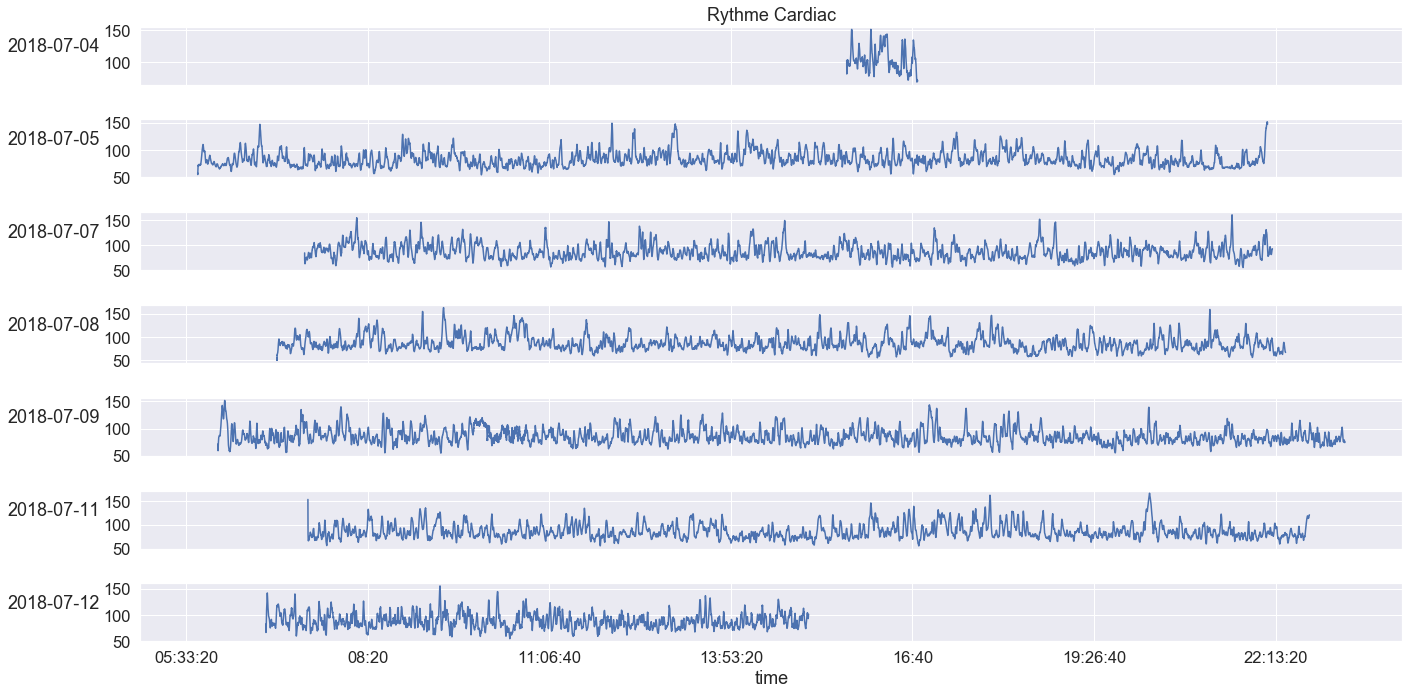

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


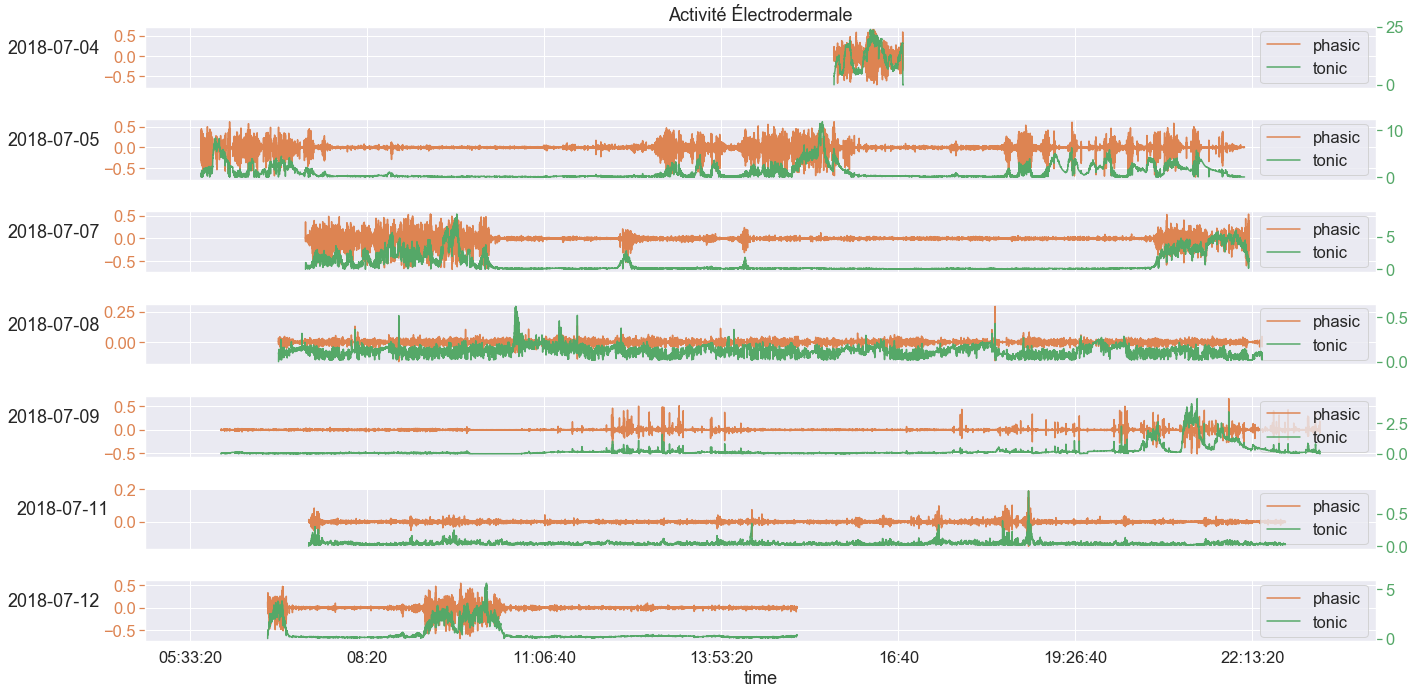

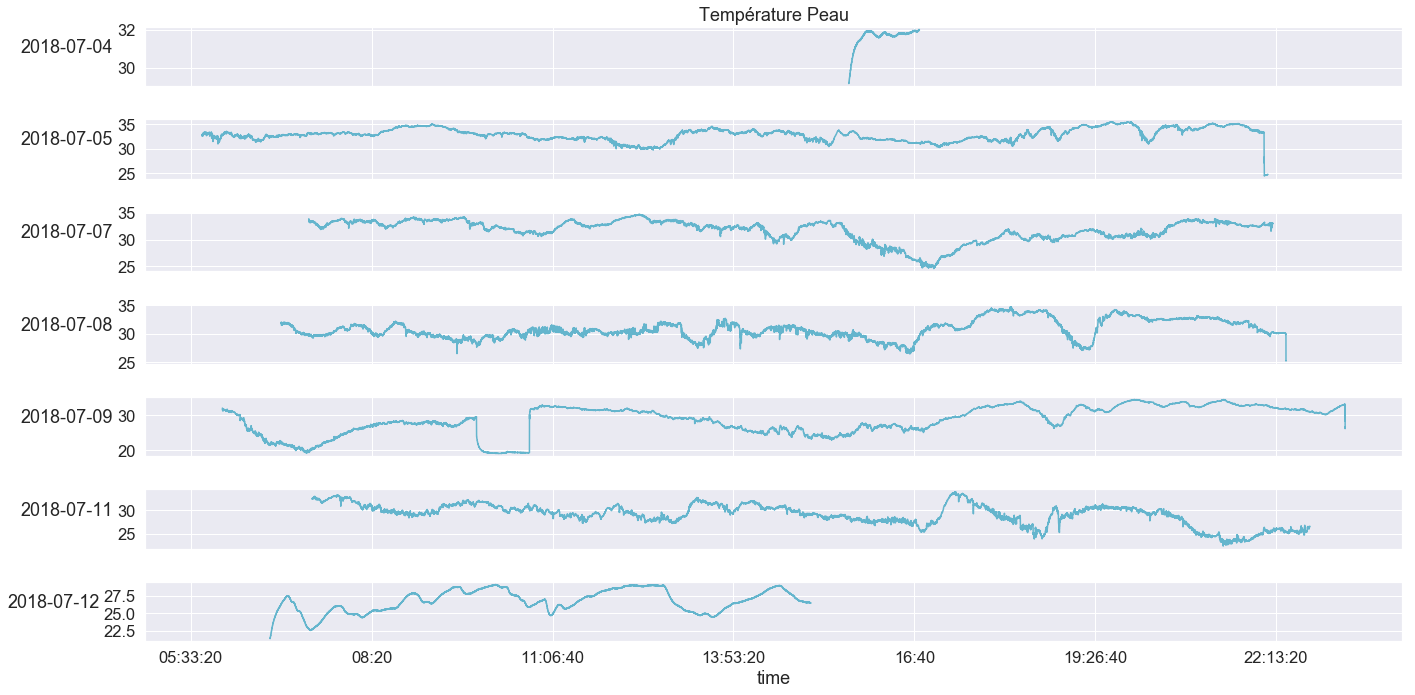

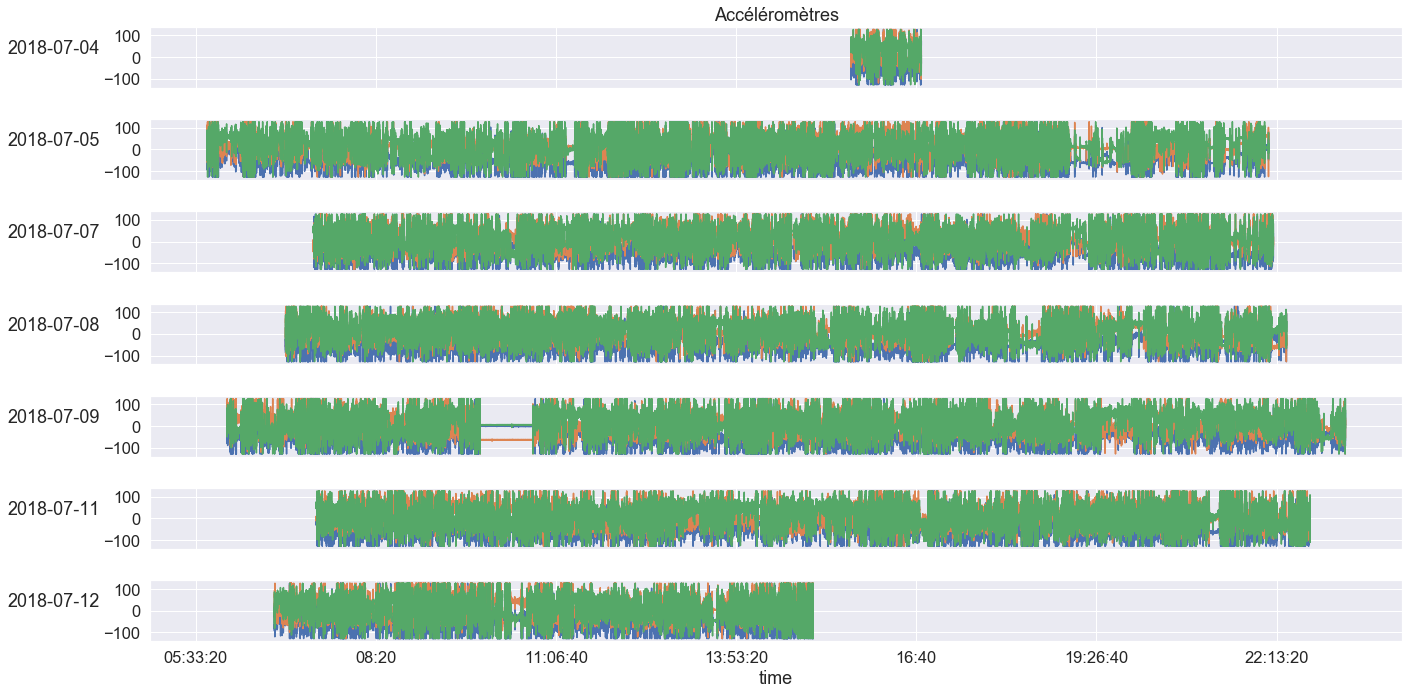

In [24]:
titles = {'HR':'Rythme Cardiac', 'EDA':'Activité Électrodermale', 'TEMP':'Température Peau', 'ACC':'Accéléromètres'}

new_color = sns.color_palette()

for sig in list(titles.keys())[:]:
    with sns.color_palette(new_color):
        new_color.append(new_color.pop(0))

        unique_days = np.unique(signals[sig].index.date)

        fig = plt.figure(figsize=(20,10))

        axs = fig.subplots(nrows=len(unique_days), sharex=True)

        for ax, date in zip(axs, unique_days):
            d = signals[sig][signals[sig].index.date == date]
            if sig in 'EDA':
                phasic, tonic = phasic_tonic(d.values)
                l1 = ax.plot(d.index.time, phasic, color=sns.color_palette()[0], label='phasic')
                # Make the y-axis label, ticks and tick labels match the line color.
                ax.tick_params('y', colors=sns.color_palette()[0])

                ax2 = ax.twinx()
                l2 = ax2.plot(d.index.time, tonic, color=sns.color_palette()[1], label='tonic')
                ax2.grid(b=False)
                ax2.tick_params('y', colors=sns.color_palette()[1])
                lns = l1+l2
                labs = [l.get_label() for l in lns]
                ax.legend(lns, labs, loc='right')
                new_color.append(new_color.pop(0))
            else:
                ax.plot(d.index.time, d.values)
            ax.set_ylabel(date, rotation=0, labelpad=50)
            ax.set_xlabel('')

        axs[0].set_title(titles[sig])
        ax.set_xlabel('time')
        fig.tight_layout()
        plt.show()


# Open IMU

In [26]:
sys.path.append(r"C:\Users\alfoc.ULAVAL\Desktop\OpenIMU\python")

from libopenimu.importers import OpenIMUImporter

from libopenimu.db.DBManager import DBManager
from libopenimu.models.Participant import Participant

DATAPATH_openimu = path.join(DATAPATH, 'OPENIMU')
sampling_rate = 50
sampling_rate_baro = 1

oi = OpenIMUImporter.OpenIMUImporter(DBManager("oi.oi"), Participant())

dfs_imu  = []
dfs_baro = []

for file in [x for x in os.listdir(DATAPATH_openimu) if '.oimu' in x][:]:
    with open(path.join(DATAPATH_openimu, file), 'rb') as f:
        data = oi.readDataFile(f)
        
    # Fix wrong timestamp
    for key in list(data.keys()):
        if key<0:
            data.pop(key)

    for timestamp, values in data.items():
        df_imu = pd.DataFrame(data=np.array(values['imu']), columns=['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz'], dtype=np.float32)
        df_imu.index  = pd.datetime.fromtimestamp(timestamp) + timedelta(seconds=1/sampling_rate) * df_imu.index
        df_baro = pd.DataFrame(data=np.array(values['baro']), columns=['temp', 'pressure'], dtype=np.float32)
        df_baro.index = pd.datetime.fromtimestamp(timestamp) + timedelta(seconds=1/sampling_rate_baro) * df_baro.index
        
        dfs_imu.append(df_imu)
        dfs_baro.append(df_baro)
        
dfs_imu = pd.concat(dfs_imu).sort_index()
dfs_baro = pd.concat(dfs_baro).sort_index()

Using sqlalchemy version:  1.2.11


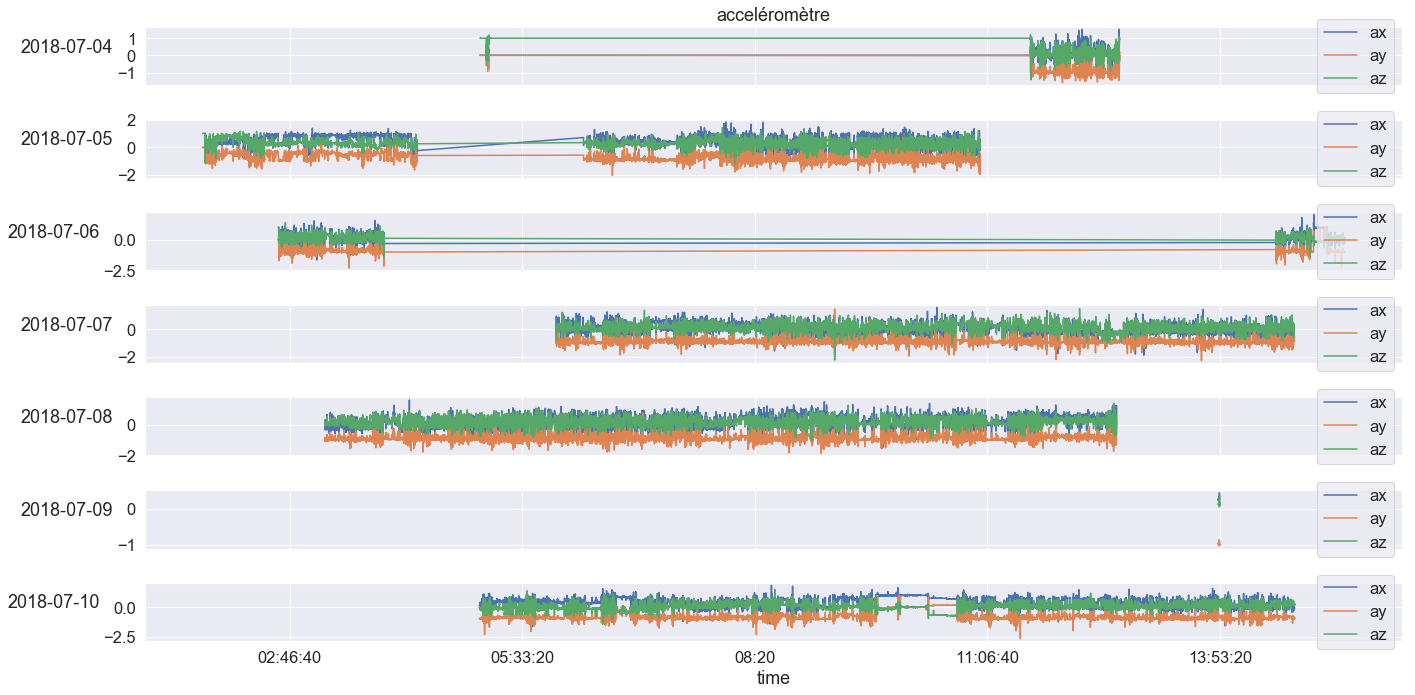

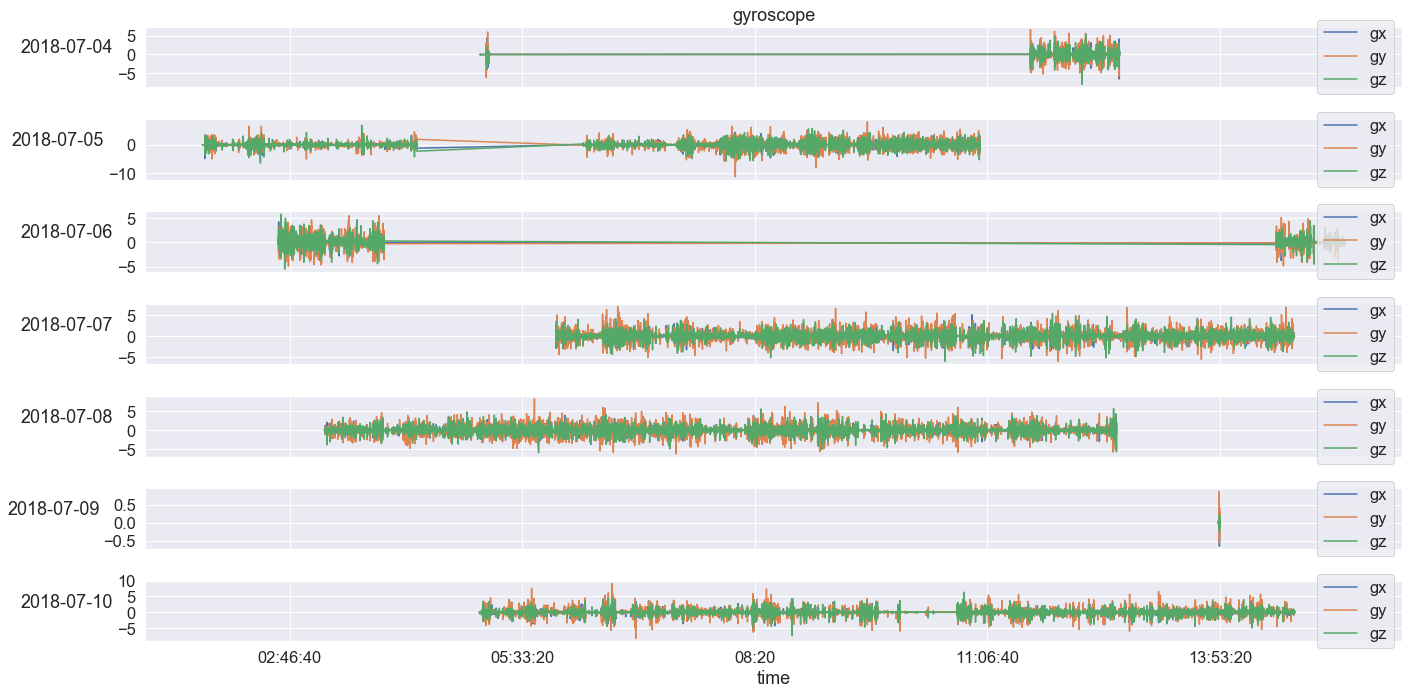

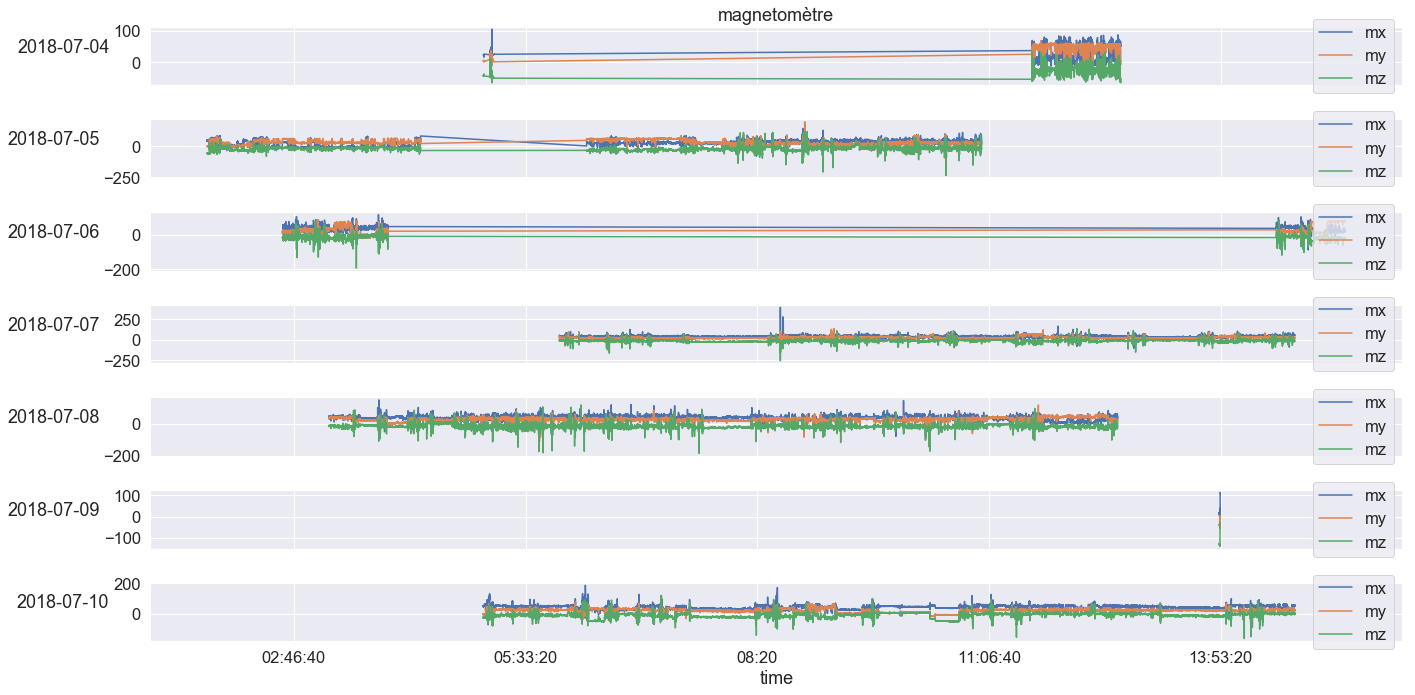

In [42]:
unique_days = np.unique(dfs_imu.index.date)[:7]

new_color = sns.color_palette()

for sig in ['acceléromètre', 'gyroscope', 'magnetomètre']:
    with sns.color_palette(new_color):
        new_color.append(new_color.pop())
        new_color.append(new_color.pop())
        new_color.append(new_color.pop())
        
        fig = plt.figure(figsize=(20,10))
        axs = fig.subplots(nrows=len(unique_days), sharex=True)

        for ax, date in zip(axs, unique_days):
            d = dfs_imu[dfs_imu.index.date == date].iloc[::50]
            d = d.loc[:, [x for x in d.columns if sig[0] in x]]
            d.index = d.index.time
            d.plot(ax=ax)
            ax.set_ylabel(date, rotation=0, labelpad=50)
            ax.set_xlabel('')
            ax.legend(loc='right')

        axs[0].set_title(sig)
        ax.set_xlabel('time')
        fig.tight_layout()
        plt.show()

In [ ]:
!jupyter  nbconvert --to=slides --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ "Analyses-SN1.ipynb"

In [ ]:
!jupyter  nbconvert --to=html --template hideinput  "Analyses-SN1.ipynb"